# <center>Assignment 4 Part 2</center>
##### <center>Robert Earle (B00758329) & Richa Khatri (B00792218)</center><center>CSCI 4155</center>
<br>

## 1. Expectation Maximization

In [0]:
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances_argmin_min

# ----- Load Dataset
iris = datasets.load_iris();

In [0]:
# ========== Expectation step ==========
def e(clusters, data, dimensions):
  
  responsibilities = np.array([])
  
  
  # ======= Handle single dimensional data
  
  if dimensions == 1:
    
    responsibilities = np.zeros(shape=(len(clusters),len(data)))
    marginals = np.zeros(shape=(len(clusters),len(data)))
  
    # ----- Loop iterates through clusters, calculates likelihoods, multiplies by mixing coefficients to get marginal
    for i, cluster in enumerate(clusters):

      # Finding likelihoods
      likelihood = 1/(np.sqrt(2*np.pi*cluster[1])) * np.exp(-np.square(data-cluster[0])/ (2*cluster[1]))
      likelihood = likelihood.ravel()

      # Retrieving mixing coefficient
      mixing_coeff = cluster[2]

      # Calculating marginal
      marginals[i] = likelihood * mixing_coeff

    # ----- Calculating the probability of x (ie. the sum of the marginals)
    prob_x = np.sum(marginals, axis=0)

    # ----- Loop calculates responsibilities
    for i, cluster in enumerate(clusters):
       responsibilities[i] = marginals[i] / prob_x
  
  
  # ======= Handle multi-dimensional data
  
  else:
    
    responsibilities = np.zeros(shape=(dimensions, len(clusters),len(data)))
    marginals = np.zeros(shape=(dimensions, len(clusters),len(data)))

    for dim in range(dimensions):

      # ----- Loop iterates through clusters, calculates likelihoods, multiplies by mixing coefficients to get marginal
      curr_dim_marginals = np.zeros(shape=(len(clusters),len(data)))
      for i, cluster in enumerate(clusters):

        # Finding likelihoods
        likelihood = 1/(np.sqrt(2*np.pi*cluster[1][dim])) * np.exp(-np.square(data[:,dim]-cluster[0][dim])/ (2*cluster[1][dim]))
        likelihood = likelihood.ravel()

        # Retrieving mixing coefficient
        mixing_coeff = cluster[2][dim]

        # Calculating marginal
        curr_dim_marginals[i] = likelihood * mixing_coeff

      # ----- Calculating the probability of x (ie. the sum of the marginals)
      prob_x = np.sum(curr_dim_marginals, axis=0)

      # ----- Loop calculates responsibilities
      curr_dim_responsibilities = np.zeros(shape=(len(clusters),len(data)))
      for i, cluster in enumerate(clusters):
        curr_dim_responsibilities[i] = curr_dim_marginals[i] / prob_x

      responsibilities[dim] = curr_dim_responsibilities
      marginals[dim] = curr_dim_marginals
    
  return responsibilities, marginals


# ---------------------------------------------------------------------------


# ========== Maximization step ==========
def m(clusters, data, dimensions, responsibilities):
  
  updated_clusters = np.zeros(shape=(clusters.shape))
  
  
  # ======= Handle single dimensional data
  
  if dimensions == 1:
  
    # ----- Loop recalculates our parameters based on responsibilities
    for i, cluster in enumerate(updated_clusters):

      # Calculating updated mu
      numerator = np.sum(data.transpose() * responsibilities[i])
      denominator = np.sum(responsibilities[i], axis=0)
      cluster[0] = numerator / denominator

      # Calculating updated sigma
      residuals = data.transpose() - cluster[0]
      squared_residuals = np.square(residuals)
      weighted_squared_residuals = responsibilities[i] * squared_residuals
      numerator = np.sum(weighted_squared_residuals)
      cluster[1] = numerator/denominator

      # Calculating updated sigma
      cluster[2] = denominator / len(data)
      
      
  # ======= Handle multi-dimensional data
      
  else:
    
    for dim in range(dimensions):
      
      # ----- Loop recalculates our parameters based on responsibilities
      for i, cluster in enumerate(updated_clusters):
        
        curr_data = np.reshape(data[:,dim],(len(data),1))
        
        # Calculating updated mu
        numerator = np.sum(curr_data.transpose() * responsibilities[dim][i])
        denominator = np.sum(responsibilities[dim][i], axis=0)
        cluster[0][dim] = numerator / denominator

        # Calculating updated sigma
        residuals = curr_data.transpose() - cluster[0][dim]
        squared_residuals = np.square(residuals)
        weighted_squared_residuals = responsibilities[dim][i] * squared_residuals
        numerator = np.sum(weighted_squared_residuals)
        cluster[1][dim] = numerator/denominator

        # Calculating updated sigma
        cluster[2][dim] = denominator / len(data)
    
  return updated_clusters


# ---------------------------------------------------------------------------


# ========== EM Algorithm ==========
def em_algorithm(clusters_init, data, dimensions):
  
  # ----- Printing initial cluster values
  print("----------> Initial Clusters")
  print(clusters_init)
  print()
  
  clusters = clusters_init
  previous_log_likelihoods = []

  # ----- While loop continuously calls E, M, and finds log likelihood until it achieves convergence
  converge = False
  iteration = 0
  while converge == False:
    iteration += 1
    
    # Running E step
    e_out = e(clusters, data, dimensions)
    responsibilities = e_out[0]
    marginals = e_out[1]
    
    # Running M step
    clusters = m(clusters, data, dimensions, responsibilities)
    
    
    # ======= Handle single dimensional data
    
    if dimensions == 1:
      
      # Calculate log likelihood
      sum_marginals = np.sum(marginals, axis=0)
      log_sum_marginals = np.log(sum_marginals)
      log_likelihood = np.sum(log_sum_marginals)

      # Outputting results
      print("----------> Updated Clusters (Iteration " + str(iteration) + "):")
      print("      mu       std div     prior")
      print(clusters)
      previous_log_likelihoods.append(log_likelihood)
      print("Log Likelihood:" + str(log_likelihood))
      print()

      # Check for convergence
      if len(previous_log_likelihoods) > 5:
        previous_log_likelihoods.pop(0)
        for prev in previous_log_likelihoods:
          converge = True
          if np.absolute(log_likelihood - prev) > 0.05:
            converge = False
            break
            
            
    # ======= Handle multi-dimensional data
    
    else:
      
      if iteration == 6:
        converge = True
      
      curr_dim_likelihood = []
      for dim in range(dimensions):
        # Calculate log likelihood
        sum_marginals = np.sum(marginals[dim], axis=0)
        log_sum_marginals = np.log(sum_marginals)
        log_likelihood = np.sum(log_sum_marginals)
        curr_dim_likelihood.append(log_likelihood)

      # Outputting results
      print("----------> Updated Clusters (Iteration " + str(iteration) + "):")
      print("    Sep Len    Sep Wid   Petal Len  Petal Wid")
      print(clusters)
      previous_log_likelihoods.append(curr_dim_likelihood)
      print("Log Likelihood:" + str(curr_dim_likelihood))
      print()

      # Check for convergence
      if len(previous_log_likelihoods) > 5:
        previous_log_likelihoods.pop(0)
        converge = True
        for i, dim in enumerate(curr_dim_likelihood):
          for j in range(len(previous_log_likelihoods)):
            if np.absolute(dim - previous_log_likelihoods[j][i]) > 0.05:
              converge = False
              break

              
  # ======= Output final results
  
  print("---------------------------------------------------------")
  print()
  print("===================> Final Gaussian Clusters:")
  if dimensions == 1:
    print("      mu       std div     prior")
  else:
    print("    Sep Len    Sep Wid   Petal Len  Petal Wid")
  print(clusters)
  print()
  print("---------------------------------------------------------")
  print()
  print()

### a)

In [0]:
# ----- Take just petal width dimension
petal_widths = iris.data[:, 3:]
dimensions = iris.data[:, 3:].shape[1]

# ----- Initializing clusters (we start off with just two)
theta1 = np.array([0.1, 0.2, 1])
theta2 = np.array([1.8, 0.3, 1])
clusters_init = np.stack((theta1, theta2))
  
# ----- Calling EM Algorithm
print("======================================================================")
print("EM Algorithm - 1D Data (petal length), Two Clusters")
print("======================================================================")
print()
em_algorithm(clusters_init, petal_widths, dimensions)

# ----- Initializing clusters (we start off with just two)
theta3 = np.array([2, 0.1, 1])
clusters_init = np.stack((theta1, theta2, theta3))
  
# ----- Calling EM Algorithm
print()
print("======================================================================")
print("EM Algorithm - 1D Data (petal length), Three Clusters")
print("======================================================================")
print()
em_algorithm(clusters_init, petal_widths, dimensions)

EM Algorithm - 1D Data (petal length), Two Clusters

----------> Initial Clusters
[[0.1 0.2 1. ]
 [1.8 0.3 1. ]]

----------> Updated Clusters (Iteration 1):
      mu       std div     prior
[[0.31401371 0.067753   0.35525783]
 [1.68715116 0.18796415 0.64474217]]
Log Likelihood:-67.9612097770976

----------> Updated Clusters (Iteration 2):
      mu       std div     prior
[[0.25659465 0.01941855 0.33592771]
 [1.67622727 0.18224417 0.66407229]]
Log Likelihood:-134.73148941744364

----------> Updated Clusters (Iteration 3):
      mu       std div     prior
[[0.24287461 0.00996442 0.32938322]
 [1.669112   0.18569007 0.67061678]]
Log Likelihood:-112.14427850312741

----------> Updated Clusters (Iteration 4):
      mu       std div     prior
[[0.23752096 0.00832402 0.32399826]
 [1.66031667 0.19386998 0.67600174]]
Log Likelihood:-106.20899668075448

----------> Updated Clusters (Iteration 5):
      mu       std div     prior
[[0.235662   0.00788199 0.32147061]
 [1.65589722 0.19840192 0.67852

### Conclusions
<br />
**Single Dimension**  
We used the petal width dimension to split up our clusters. We chose this dimension because after looking at the scatterplots it seemed like the datapoints formed three clear clusters across this axis.
<br />  
**Two Clusters**  
We were able to separate the petal widths into two clusters. The initial values were estimated based on the values in the scatterplots:
> ----- *Cluster 1*   
>  mu = 0.2  
> sigma = 0.2  
> prior = 1  
<br />
> ----- *Cluster 2*   
>  mu = 1.8  
> sigma = 0.3  
> prior = 1  

After running our algorithm our clusters converged to:  
> ----- *Cluster 1*   
>  mu = 0.23437271  
> sigma = 0.0076119  
> prior = 0.31946648  
<br />
> ----- *Cluster 2*   
>  mu = 1.65231995  
> sigma = 0.20217504  
> prior = 0.68053352  

In this case versicolor and virginica get grouped together. Looking at the scatterplot we see that these two flowers form two distinct clusters, but these clusters are right next to one another with a slight amount of overlap - thus it makes sense that, given two clusters to represent our data, our algorithm would consider these two clusters to be one big cluster.
<br />  
**Three Clusters**  
Again we used petal widths for our three clusters, for the reasons mentioned above. We kept the initial values from the first two clusters, and added a third initial cluster:
> ----- *Cluster 3*   
>  mu = 2 
> sigma = 0.1  
> prior = 1  

After running our algorithm our clusters converged to:  
> ----- *Cluster 1*   
>  mu = 0.23893824  
> sigma = 0.00860806  
> prior = 0.32660788  
<br />
> ----- *Cluster 2*   
>  mu = 1.37618106  
> sigma = 0.06865494  
> prior = 0.40244476  
<br />
> ----- *Cluster 3*   
>  mu = 2.09434547  
> sigma = 0.05836548  
> prior = 0.27094735  

This time we were able to form three distinct clusters, each one corresponding fairly accurately to one of the three flowers. We notice that the parameters of cluster 1 converged to roughly the same values as it did with only two clusters, where as cluster 2 has changed significantly. This is because the setosa flowers have petal widths that are relatively small compared to the other two, so the datapoints belonging to this flower are all separated from the others in this dimension. Therefore in both cases our first cluster is modeling the same set of data points, as it was purposely initialized to be centered in this area. Cluster 2 changed significantly because, with the introduction of a third cluster, we were able to split the one large cluster mentioned above into two smaller clusters.

### b)

In [0]:
# ----- Load full dataset
data = iris.data
dimensions = data.shape[1]

# ----- Initializing Clusters
theta1 = np.array([
    [4.7, 3.3, 1.4, 0.1],
    [0.2, 0.2, 0.2, 0.2],
    [1.0, 1.0, 1.0, 1.0]
                  ])

theta2 = np.array([
    [5.5, 2.8, 4.4, 1.8],
    [0.6, 0.3, 0.5, 0.3],
    [1.0, 1.0, 1.0, 1.0]
                  ])

theta3 = np.array([
    [6.3, 3.2, 5.8, 2.0],
    [0.4, 0.5, 0.6, 0.1],
    [1.0, 1.0, 1.0, 1.0]
                  ])
clusters_init = np.stack((theta1, theta2, theta3))

# ----- Calling EM Algorithm
print()
print("======================================================================")
print("EM Algorithm - 4D Data, Three Clusters")
print("======================================================================")
print()
em_algorithm(clusters_init, data, dimensions)


EM Algorithm - 4D Data, Three Clusters

----------> Initial Clusters
[[[4.7 3.3 1.4 0.1]
  [0.2 0.2 0.2 0.2]
  [1.  1.  1.  1. ]]

 [[5.5 2.8 4.4 1.8]
  [0.6 0.3 0.5 0.3]
  [1.  1.  1.  1. ]]

 [[6.3 3.2 5.8 2. ]
  [0.4 0.5 0.6 0.1]
  [1.  1.  1.  1. ]]]

----------> Updated Clusters (Iteration 1):
    Sep Len    Sep Wid   Petal Len  Petal Wid
[[[4.95307161 3.18348853 1.46255542 0.3074617 ]
  [0.11671941 0.14398154 0.03048459 0.06155044]
  [0.22115585 0.34860872 0.33338408 0.35288465]]

 [[5.7313007  2.88955372 4.45962222 1.54246979]
  [0.45815257 0.15038583 0.37725968 0.18679627]
  [0.34706982 0.34533552 0.38218552 0.37500028]]

 [[6.38938185 3.1029507  5.50575562 1.8830571 ]
  [0.43522649 0.23093788 0.44847038 0.12239616]
  [0.43177433 0.30605576 0.2844304  0.27211507]]]
Log Likelihood:[-31.117330741878042, 62.094416456534134, -68.2529967708079, -8.59074753350937]

----------> Updated Clusters (Iteration 2):
    Sep Len    Sep Wid   Petal Len  Petal Wid
[[[4.9616843  3.17261546 1.46

### Conclusions
<br />
*NOTE: this time the dimensions of our output is different than the single dimensional version in A. I don't know why I did this but I didn't notice until both had been implemented and I'm too lazy to go back and change it.*
<br />  
This time our algorithm converged with the following results:  
> ----- *Cluster 1*   
>  mu = [4.89870108, 3.10315887, 1.46198059, 0.23893824]  
> sigma = [0.07659784, 0.19821061, 0.02954899, 0.00860806]  
> prior = [0.24074088, 0.31888194, 0.33331773, 0.32660788]  
<br />
> ----- *Cluster 2*   
>  mu = [5.78943457, 2.90110426, 4.45278965, 1.37618106]  
> sigma = [0.28153434, 0.09538255, 0.36285071, 0.06865494]  
> prior = [0.34380803, 0.38640591, 0.38784266, 0.40244476]  
<br />
> ----- *Cluster 3*   
>  mu = [6.43532221, 3.21258618, 5.53620836, 2.09434547]  
> sigma = [0.49217328, 0.24242736, 0.42622915, 0.05836548]  
> prior = [0.41545109, 0.29471215, 0.2788396, 0.27094735]  

We notice that, in the fourth dimension (ie. the fourth element in all the vectors above), the results converge to exactly the same values as they did in the one dimensional, three cluster example from (a). This makes sense, as in finding our parameter estimates we are calculating each dimension's estimates independent of the others.``

## 2. Breaking K Means

In [0]:
def synth_gussian_cluster_data(num_points, num_classes,synth_data_no):
    
    if num_points <= 0 or num_classes <= 0:
      print("Error - input variables cannot be negative")
      return
    
    data = []
    centers = []
    variances = []
    
    if synth_data_no==1:
      # Get cluster centers
      for i in range(num_classes):
        c = np.random.rand(2)
        centers.append(c)
        variances.append(np.abs(np.random.normal(10, 2)))

      for i in range(num_points):
        curr_cluster = np.random.randint(num_classes)
        data.append(np.random.normal(centers[curr_cluster],variances[curr_cluster]))
    elif synth_data_no==2:
          for i in range(num_classes):
            c = np.random.uniform(0.6, 1,2)
            c_1=np.array((6,4))
            centers.append(c)
            centers.append(c_1)
            variances.append(np.abs(np.random.normal(1,0.2)))
          for i in range(num_points):
            curr_cluster = np.random.randint(num_classes)
            data.append(np.random.normal(centers[curr_cluster],variances[curr_cluster]))
    elif synth_data_no==3:
          for i in range(num_classes):
            c = np.random.uniform(6,7,2)
            c_1=np.array((0.1,2.2))
            c_2=np.array((0.1,10))
            centers.append(c)
            centers.append(c_1)
            centers.append(c_2)
            variances.append(np.abs(np.random.normal(1,0.4)))
          for i in range(num_points):
            curr_cluster = np.random.randint(num_classes)
            data.append(np.random.normal(centers[curr_cluster],variances[curr_cluster]))
    elif synth_data_no==4:
          for i in range(num_classes):
            c = np.random.uniform(6,7,2)
            centers.append(c)
            variances.append(np.abs(np.random.normal(1,0.4)))
          for i in range(num_points):
            curr_cluster = np.random.randint(num_classes)
            data.append(np.random.normal(np.random.uniform(0.6, 1,2)))
            data.append([7,7])
            data.append([0,2])
            data.append([14,17])
    elif synth_data_no==5:
          for i in range(num_classes):
            c = np.random.uniform(6,7,2)
            centers.append(c)
            variances.append(np.abs(np.random.normal(1,0.4)))
          for i in range(num_points):
            curr_cluster = np.random.randint(num_classes)
            data.append(np.random.normal(np.random.uniform(0.6, 1,2)))
            data.append([7,7])
            data.append([9,9])
            data.append([0,2])
            data.append([14,17])
    else:
          for i in range(num_points):

            curr_cluster = np.random.randint(num_classes)

            # Randomizing Polar Coordinates
            if curr_cluster == 0:
              radius = np.random.uniform(0,4)
            else:
              radius = np.random.uniform(4+2*curr_cluster,6+2*curr_cluster)

            # Convert to decimal and add to output
            theta = np.radians(np.random.uniform(0,359))
            new_point = []
            new_point.append(radius*np.cos(theta))
            new_point.append(radius*np.sin(theta))

            data.append(new_point)      

    return data,centers

----------------------First Synthetic data set--------------------------
------Actual centers of the cluster---------------------
[[0.7089047  0.11954466]
 [0.59654203 0.02088255]]
------Predicted centers by K means algorithm-----------
[[ 8.10181968 -8.5352104 ]
 [-3.99652461  5.68020981]]


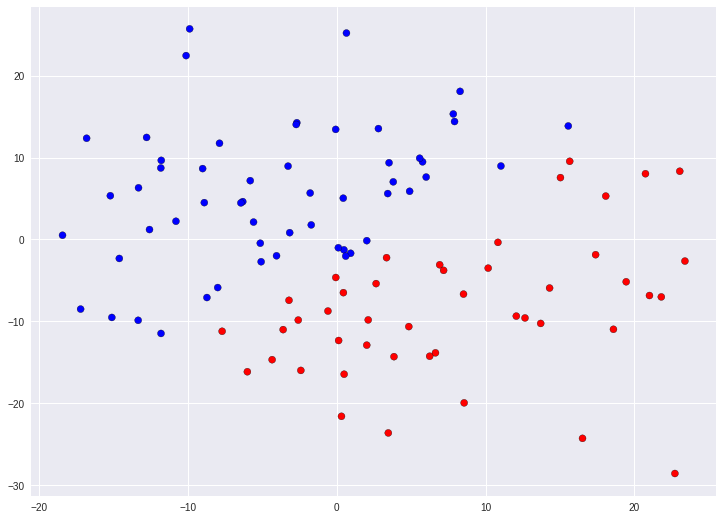

In [0]:
figure = plt.figure(figsize=(27, 9))

print("----------------------First Synthetic data set--------------------------")
data,centers=synth_gussian_cluster_data(num_points=100, num_classes=2,synth_data_no=1)
print("------Actual centers of the cluster---------------------")
print(np.array(centers))
# y_pred = KMeans(n_clusters=2).fit_predict(data)
km = KMeans(n_clusters=2).fit(data)
print("------Predicted centers by K means algorithm-----------")
print(km.cluster_centers_)
data=np.array(data)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, 2, 1)
ax.scatter(data[:, 0], data[:, 1], c=km.labels_, cmap=cm_bright,
               edgecolors='k')

----------------------Second Synthetic data set--------------------------
------Actual centers of the cluster---------------------
[[0.84425921 0.73616075]
 [6.         4.        ]
 [0.80798058 0.64476103]
 [6.         4.        ]]
------Predicted centers by K means algorithm-----------
[[6.04477086 3.94489047]
 [0.78067449 0.75119929]]


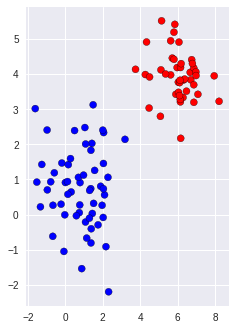

In [0]:
print("----------------------Second Synthetic data set--------------------------")
data_2,centers_2=synth_gussian_cluster_data(num_points=100, num_classes=2,synth_data_no=2)
# print(data_2)
print("------Actual centers of the cluster---------------------")
print(np.array(centers_2))
# y_pred = KMeans(n_clusters=2).fit_predict(data)
km_2 = KMeans(n_clusters=2).fit(data_2)
print("------Predicted centers by K means algorithm-----------")
print(km_2.cluster_centers_)
data_2=np.array(data_2)
cm_2 = plt.cm.RdBu
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax_2 = plt.subplot(1, 2, 1)
ax_2.scatter(data_2[:, 0], data_2[:, 1], c=km_2.labels_, cmap=cm_bright,
               edgecolors='k')

----------------------Third Synthetic data set--------------------------
------Actual centers of the cluster---------------------
[[ 6.34862822  6.33777284]
 [ 0.1         2.2       ]
 [ 0.1        10.        ]
 [ 6.20705799  6.28447195]
 [ 0.1         2.2       ]
 [ 0.1        10.        ]]
------Predicted centers by K means algorithm-----------
[[0.78067449 0.75119929]
 [6.04477086 3.94489047]]


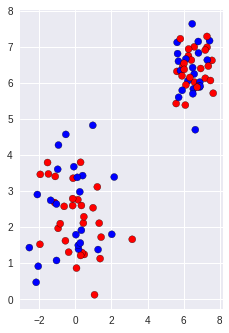

In [0]:
print("----------------------Third Synthetic data set--------------------------")
data_3,centers_3=synth_gussian_cluster_data(num_points=100, num_classes=2,synth_data_no=3)
print("------Actual centers of the cluster---------------------")
print(np.array(centers_3))
# y_pred = KMeans(n_clusters=2).fit_predict(data)
km_3 = KMeans(n_clusters=2).fit(data_2)
print("------Predicted centers by K means algorithm-----------")
print(km_3.cluster_centers_)
data_3=np.array(data_3)
ax_3 = plt.subplot(1, 2, 1)
ax_3.scatter(data_3[:, 0], data_3[:, 1], c=km_3.labels_, cmap=cm_bright,
               edgecolors='k')


----------------------Fourth Synthetic data set--------------------------
------Actual centers of the cluster---------------------
[[6.16407011 6.89982001]
 [6.16067254 6.31839096]]
------Predicted centers by K means algorithm-----------
[[ 2.57259298  3.26351703]
 [14.         17.        ]]


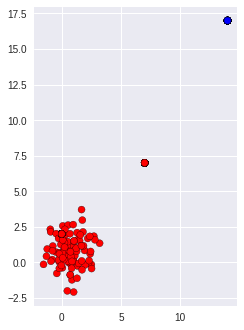

In [0]:
print("----------------------Fourth Synthetic data set--------------------------")
data_4,centers_4=synth_gussian_cluster_data(num_points=100, num_classes=2,synth_data_no=4)
print("------Actual centers of the cluster---------------------")
print(np.array(centers_4))
# y_pred = KMeans(n_clusters=2).fit_predict(data)
km_4 = KMeans(n_clusters=2).fit(data_4)
print("------Predicted centers by K means algorithm-----------")
print(km_4.cluster_centers_)
data_4=np.array(data_4)
ax_4 = plt.subplot(1, 2, 1)
ax_4.scatter(data_4[:, 0], data_4[:, 1], c=km_4.labels_, cmap=cm_bright,
               edgecolors='k')


----------------------Fifth Synthetic data set--------------------------
------Actual centers of the cluster---------------------
[[6.20525089 6.05952895]
 [6.97745182 6.11031215]]
------Predicted centers by K means algorithm-----------
[[ 0.39171376  1.45739288]
 [10.         11.        ]]


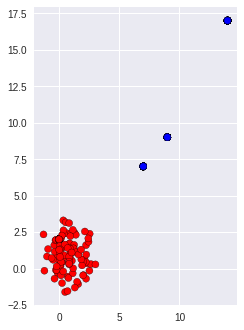

In [0]:
print("----------------------Fifth Synthetic data set--------------------------")
data_5,centers_5=synth_gussian_cluster_data(num_points=100, num_classes=2,synth_data_no=5)
print("------Actual centers of the cluster---------------------")
print(np.array(centers_5))
# y_pred = KMeans(n_clusters=2).fit_predict(data)
km_5 = KMeans(n_clusters=2).fit(data_5)
print("------Predicted centers by K means algorithm-----------")
print(km_5.cluster_centers_)
data_5=np.array(data_5)
ax_5 = plt.subplot(1, 2, 1)
ax_5.scatter(data_5[:, 0], data_5[:, 1], c=km_5.labels_, cmap=cm_bright,
               edgecolors='k')


----------------------Fifth Synthetic data set--------------------------
------Predicted centers by K means algorithm-----------
[[-1.93241168 -1.46046694]
 [ 2.90938314  3.16722259]]


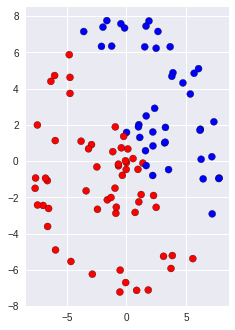

In [0]:
print("----------------------Fifth Synthetic data set--------------------------")
data_6,centers_6=synth_gussian_cluster_data(num_points=100, num_classes=2,synth_data_no=0)
# y_pred = KMeans(n_clusters=2).fit_predict(data)
km_6 = KMeans(n_clusters=2).fit(data_6)
print("------Predicted centers by K means algorithm-----------")
print(km_6.cluster_centers_)
data_6=np.array(data_6)
ax_6 = plt.subplot(1, 2, 1)
ax_6.scatter(data_6[:, 0], data_6[:, 1], c=km_6.labels_, cmap=cm_bright,
               edgecolors='k')

### K-means 
<br />
**Assumptions**

In first two example we generate highly randomized dataset which resulted in completely wrong predictions of centers. Hence we can say that, K means did not perform well with random data as points are spread all over the two axes and visually as well. K-means tries to produce “tight” clusters. In attempting to minimize the intra-cluster distances between the points in the large cluster it’s “overdone” things and produced two clusters that have similar intra-cluster distances

A shown in synthetic dataset number 3, different cluster centers were used to generate highly randomized dataset. As a result the points were not classified properly visually as well as the prediction of cluster center was not correct. Due to high difference in centers, K means algorithm tries to converge all its point near those centers which results in misclassification.

K means algorithm is uses clustering based on mean square distance amongst different data points. It is an unsupervised learning algorithm that tries to classify each and every data points. As shown in fourth synthetic and fifth synthetic dataset, we tried to make few points very far from the cluster of points. K means classified differently in both cases, because of addition of one point this is due to taking into consideration mean square distances and not the co variance to determine the distribution. Also, the custer centers were highly mislassified in both the cases eventhough in plotting it doesn't appear but K means did misclassification in both the cases.

In the last example, the two sphere, but K means is completely violeting this assumption. So it is not good at classifying the spherical dataset. Due to tight coupling, it assigns some data points in the first cluster to the second cluster incorrectly. This makes the clustering inaccurate.

Hence, in all conditions K means did not performed well so we can say that K-means does not perform well in following scenarios
1) Data with high variance.
2) Circular Dataset.
3) Random data.
